In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from OnlineLODA import OnlineLODA
from sklearn.metrics import roc_auc_score

In [2]:
datasets = ['cover.csv', 'creditcardfraud_normalised.csv', 'musk.csv', 'http.csv', 'smtp.csv', 'mammography.csv']

In [3]:
datasets

['cover.csv',
 'creditcardfraud_normalised.csv',
 'musk.csv',
 'http.csv',
 'smtp.csv',
 'mammography.csv']

In [4]:
datasets[0][:-4]

'cover'

In [5]:
def loader(i):
    df = pd.read_csv(f'../datasets/{i}', header=None)
    batch_size = max(200, round(df.shape[0]//200, -2))
    data = df[df.columns[:-1]].values
    label = df[df.columns[-1]].values
    return data, label, batch_size

In [6]:
for d in datasets:
    data, label, bs = loader(d)
    print(f'{d}\t{label.shape[0]}\t{np.sum(label==1)}\t{np.sum(label==0)}')

cover.csv	286048	2747	283301
creditcardfraud_normalised.csv	284807	492	284315
musk.csv	3062	97	2965
http.csv	567498	2211	565287
smtp.csv	95156	30	95126
mammography.csv	11183	260	10923


In [7]:
import matplotlib.dates as mdates


def anosc_plot(preds, label, filename = None):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(preds.shape)
    ax.scatter(np.arange(preds.shape[0])[label==0], preds[label==0], color="blue", s=0.2, rasterized=True)
    ax.scatter(np.arange(preds.shape[0])[label==1], preds[label==1], color="red", s=0.2, rasterized=True)
    
    # ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%j'))
    ax.legend(['Normal', 'Anomaly'])
    
    # ax.vlines(mixed_dates, 0,35, linewidth=0.2, color="black")
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename, dpi=300)
    #plt.show()

# Global LODA

In [8]:
from LODANP import LODA

In [9]:
def do_data_set(dataset):
    x,label,bs = loader(dataset)
    b_results = pd.DataFrame(columns=np.arange(20))
    b_aucs = []

    for i in np.arange(20):
        print(f"           of round {i+1}, {dataset}", end='\r')
        b = LODA(X=x)
        b_preds = b.predict(X=x)
        b_results[i] = b_preds
        b_aucs.append(roc_auc_score(y_true=label, y_score=b_preds))
        
    anosc_plot(b_results.mean(axis=1), label, None)
    return np.mean(b_aucs), np.std(b_aucs), bs

In [11]:
results = []

'Batch 99'

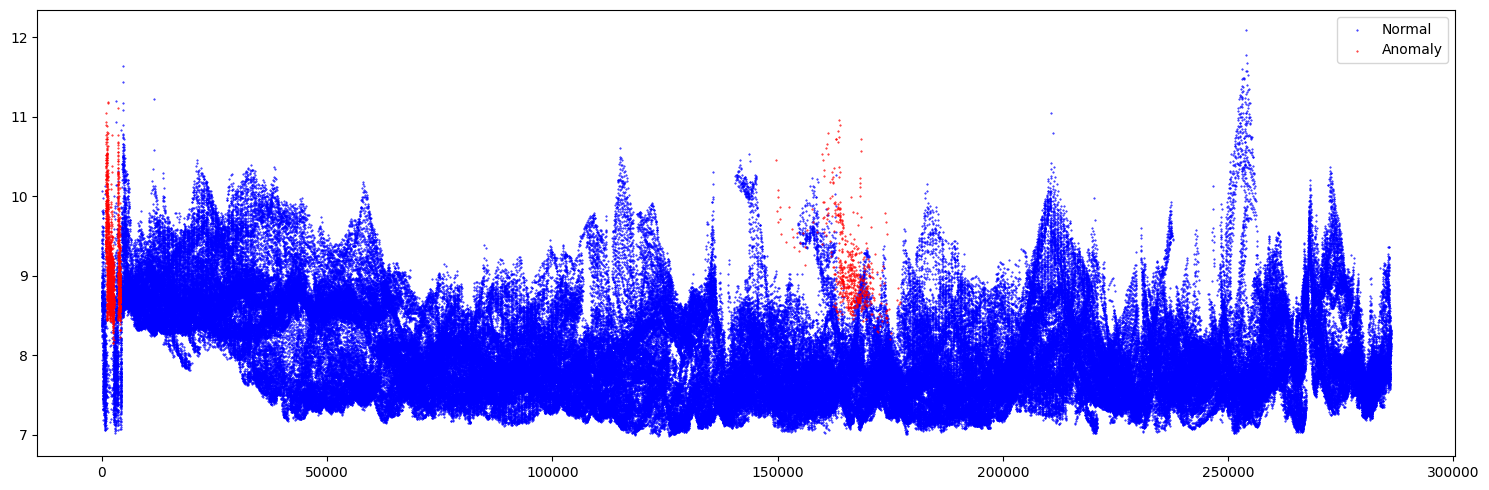

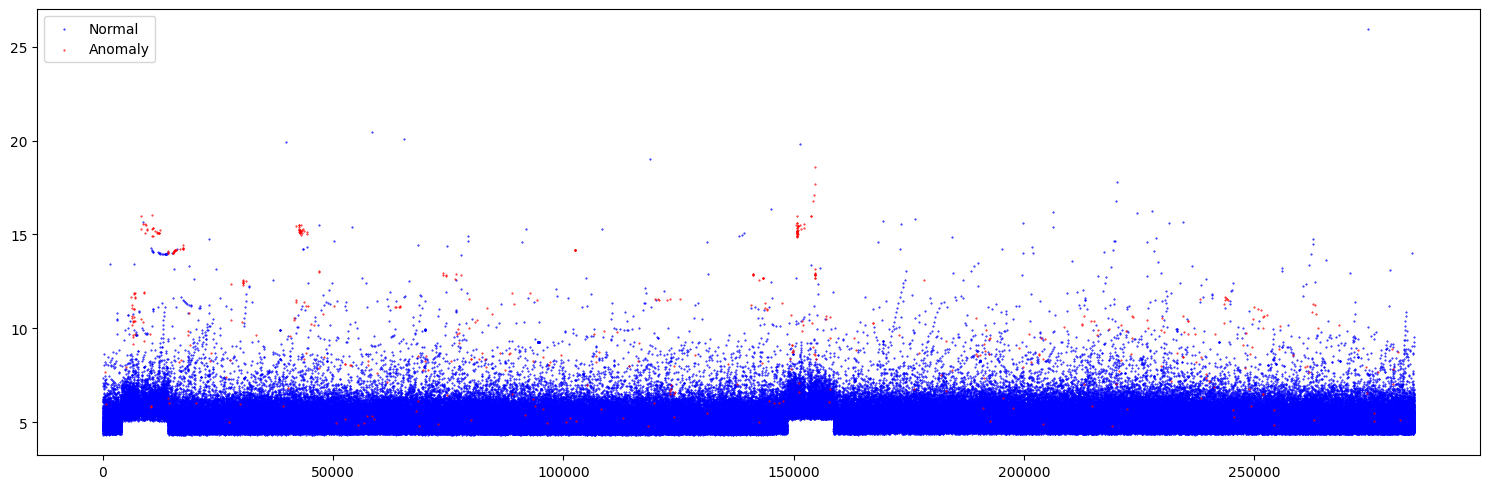

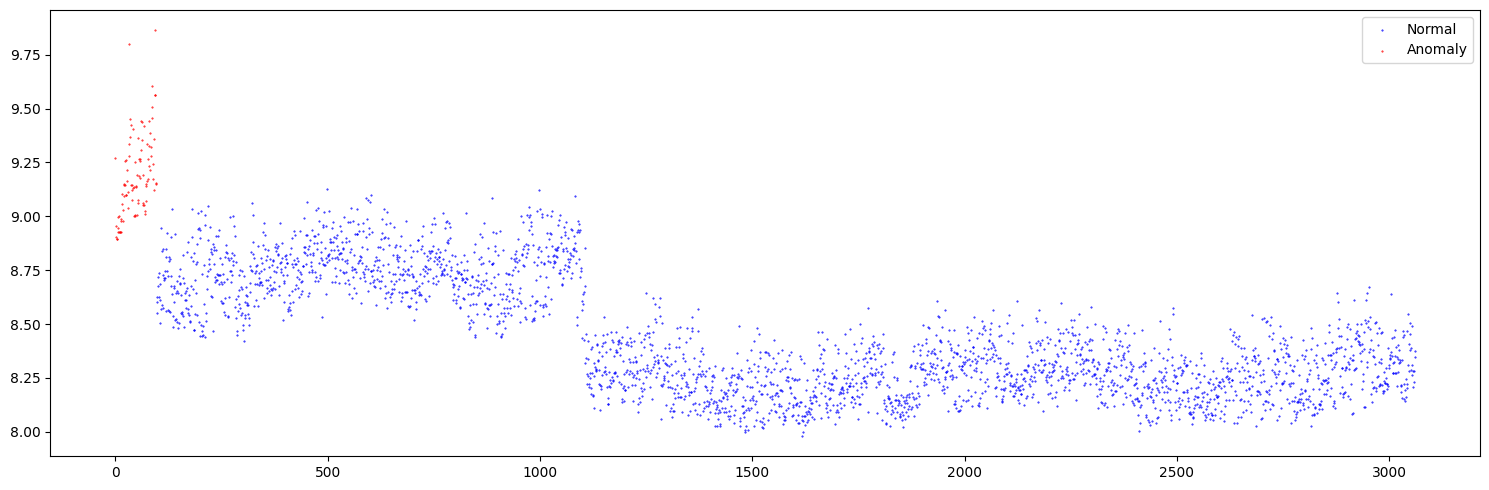

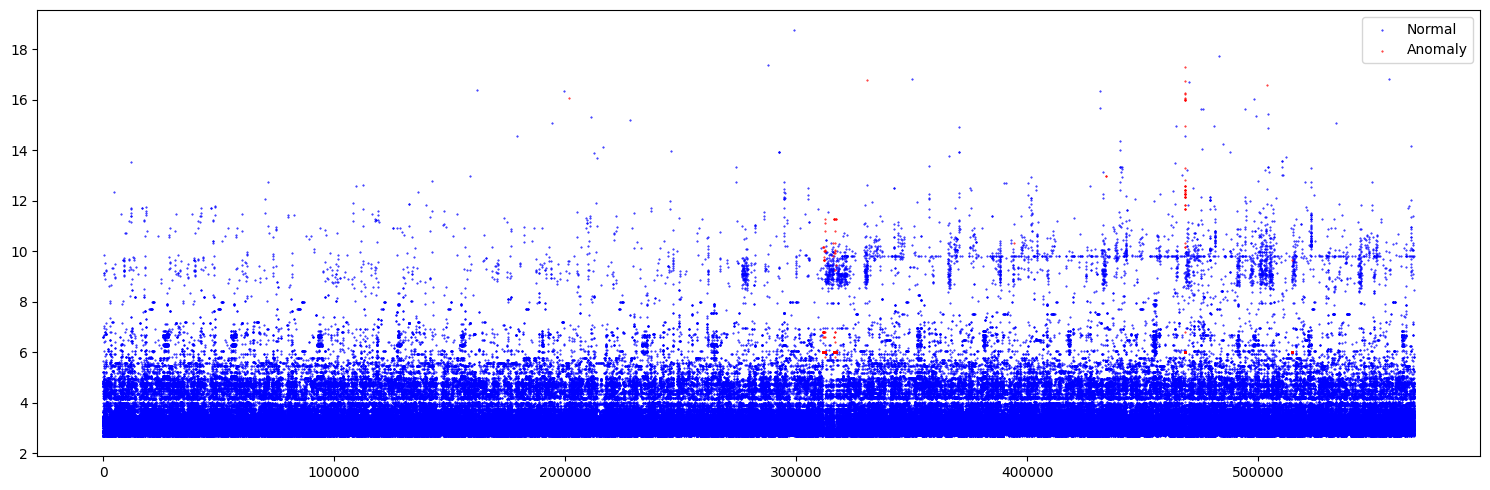

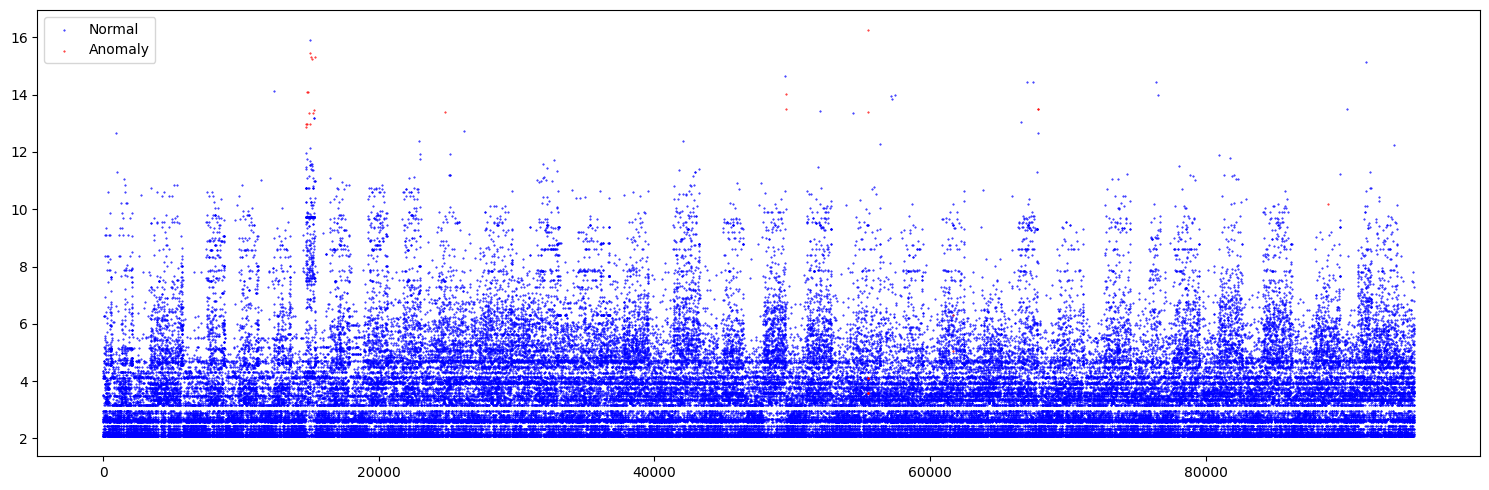

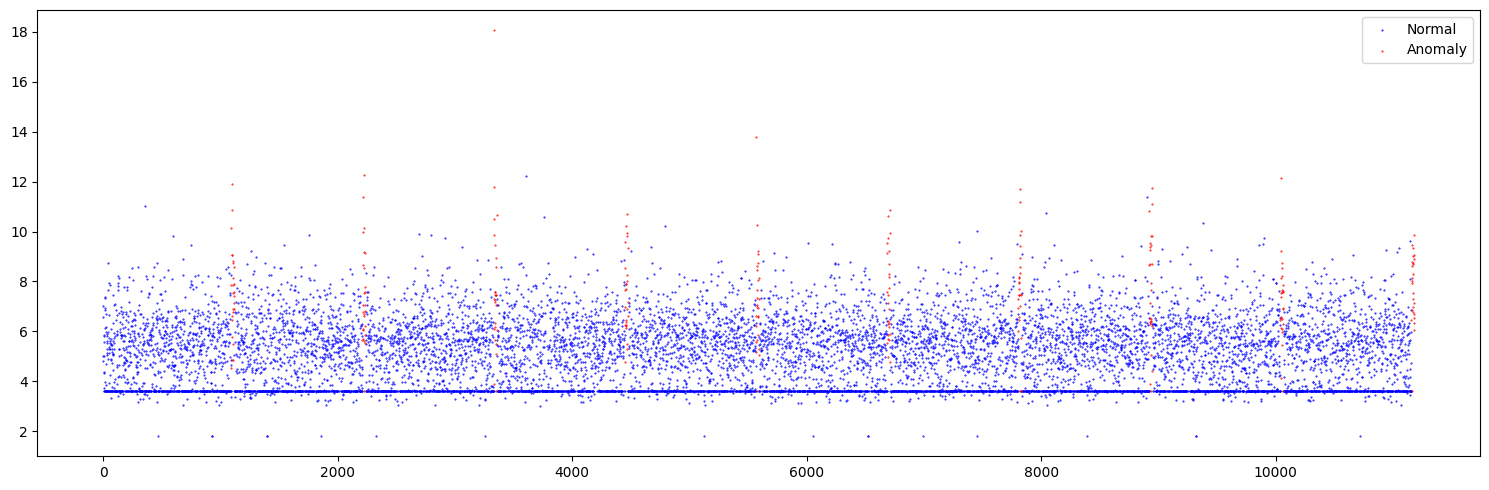

In [12]:
for d in datasets:
    aucm, aucs, bs = do_data_set(d)
    results.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':1})

In [13]:
results

[{'dataset': 'cover.csv',
  'mean': 0.8972559532427011,
  'std': 0.04850271338027914,
  'bs': 1400,
  'hpb': 1},
 {'dataset': 'creditcardfraud_normalised.csv',
  'mean': 0.9553583073509015,
  'std': 0.002235462196348679,
  'bs': 1400,
  'hpb': 1},
 {'dataset': 'musk.csv',
  'mean': 0.9631357243441526,
  'std': 0.025237828496947976,
  'bs': 200,
  'hpb': 1},
 {'dataset': 'http.csv',
  'mean': 0.9833413793817106,
  'std': 0.0031212191938852184,
  'bs': 2800,
  'hpb': 1},
 {'dataset': 'smtp.csv',
  'mean': 0.9159095305174191,
  'std': 0.011596675432932992,
  'bs': 500,
  'hpb': 1},
 {'dataset': 'mammography.csv',
  'mean': 0.8573364337072796,
  'std': 0.018334645012350922,
  'bs': 200,
  'hpb': 1}]

In [14]:
pd.DataFrame.from_dict(results)

,dataset,mean,std,bs,hpb
0,cover.csv,0.897256,0.048503,1400,1
1,creditcardfraud_normalised.csv,0.955358,0.002235,1400,1
2,musk.csv,0.963136,0.025238,200,1
3,http.csv,0.983341,0.003121,2800,1
4,smtp.csv,0.915910,0.011597,500,1
5,mammography.csv,0.857336,0.018335,200,1


In [ ]:
pd.DataFrame.from_dict(results).to_csv('lodal_global.csv')

# Repeated experiment with ALTER LDOA

In [9]:
def do_data_set_alter(dataset):
    x,label,bs = loader(dataset)
    b_results = pd.DataFrame(columns=np.arange(20))
    b_aucs = []
    
    for i in np.arange(20):
        print(f"           of round {i+1}, {dataset}", end='\r')
        b_preds = []
        for k in range(x.shape[0]//bs):
            if(k==0):
                b1 = LODA(X=x[k*bs:(k+1)*bs])
                b_preds.append(b1.predict(X=x[k*bs:(k+1)*bs]))
            elif(k%2==0):
                b1 = LODA(X=x[k*bs:(k+1)*bs])
                if(k==x.shape[0]//bs-1):
                    b_preds.append(b2.predict(X=x[k*bs:]))
                else:
                    b_preds.append(b2.predict(X=x[k*bs:(k+1)*bs]))
            else:
                b2 = LODA(X=x[k*bs:(k+1)*bs])
                if(k==x.shape[0]//bs-1):
                    b_preds.append(b1.predict(X=x[k*bs:]))
                else:
                    b_preds.append(b1.predict(X=x[k*bs:(k+1)*bs]))
        b_results[i] = np.hstack(b_preds)
        b_aucs.append(roc_auc_score(y_true=label, y_score=b_results[i]))
        
    anosc_plot(b_results.mean(axis=1), label, None)
    return np.mean(b_aucs), np.std(b_aucs), bs

In [11]:
results_alter = []

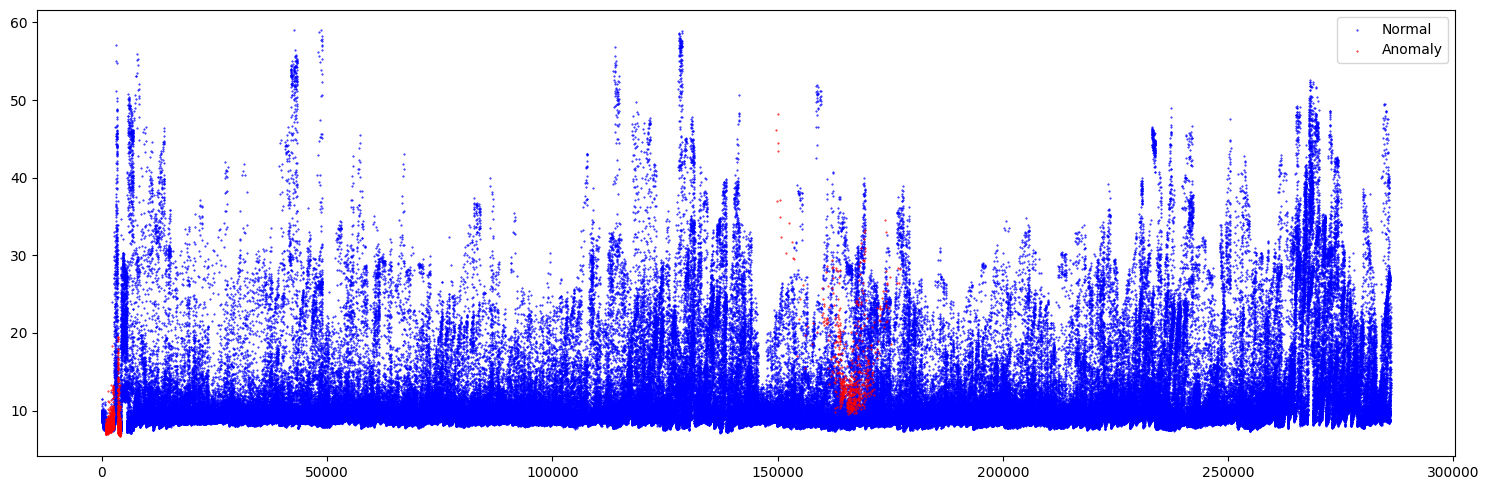

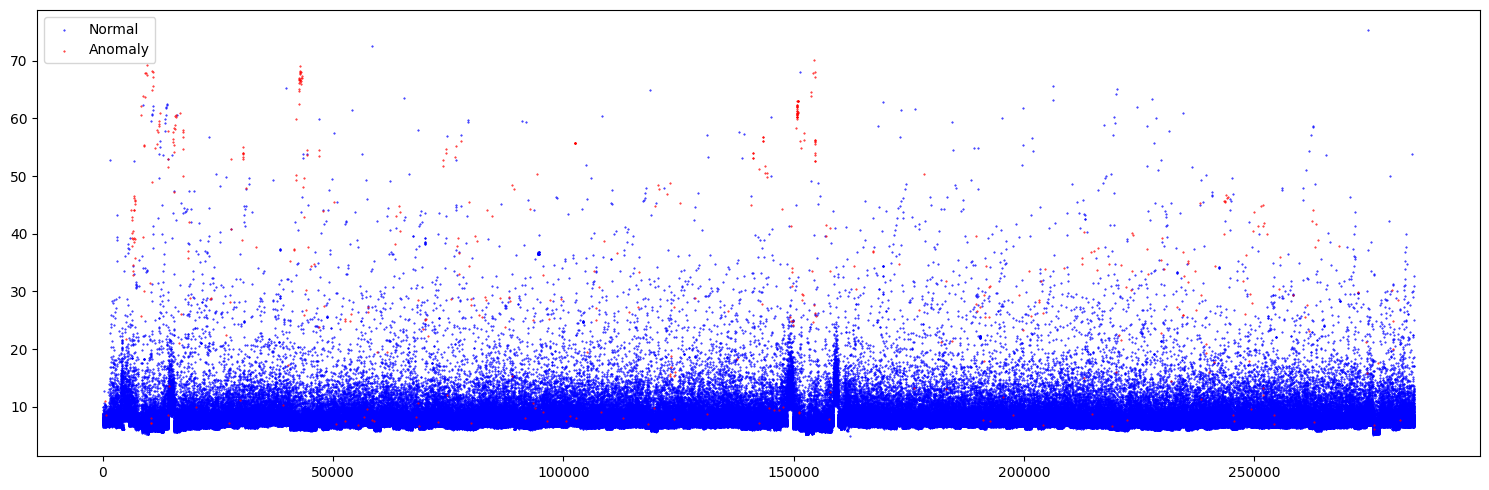

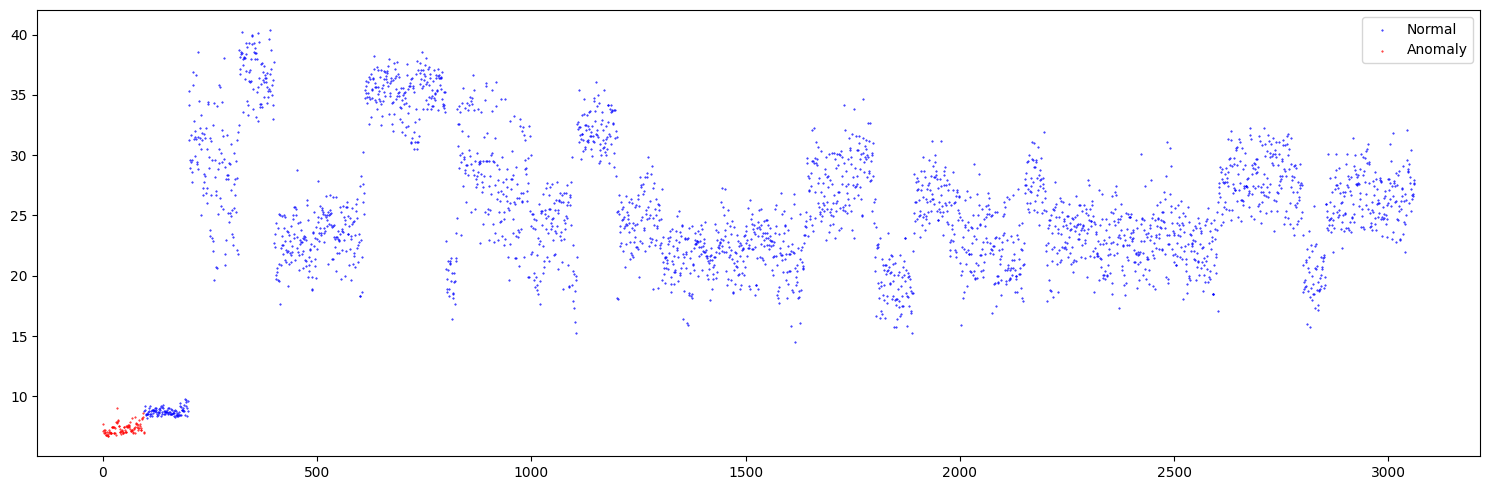

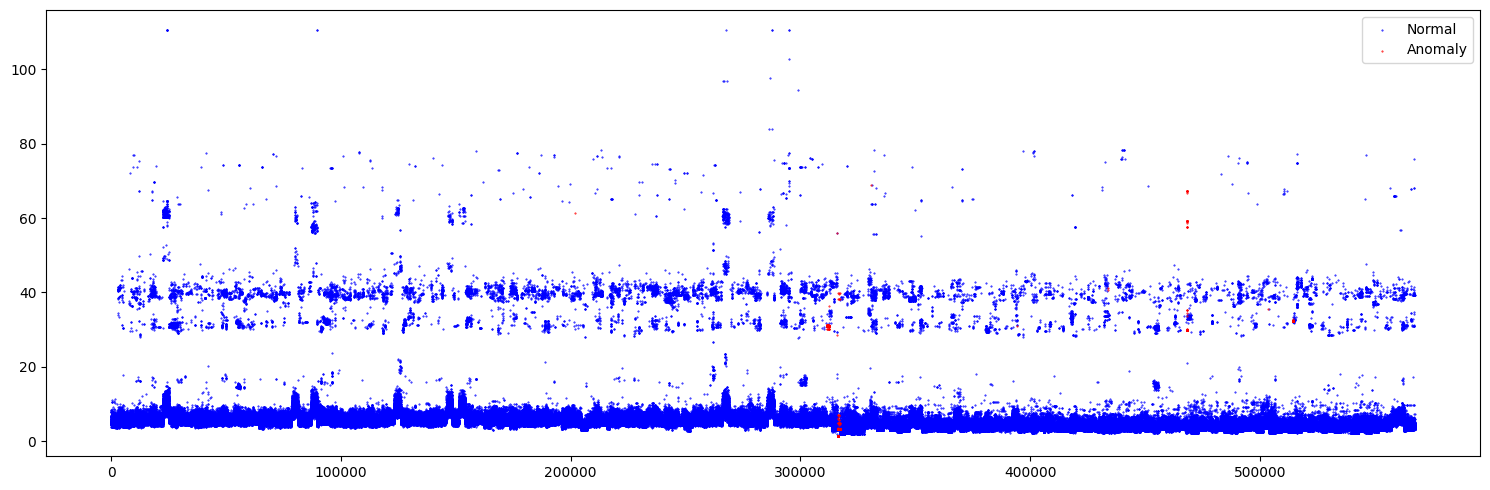

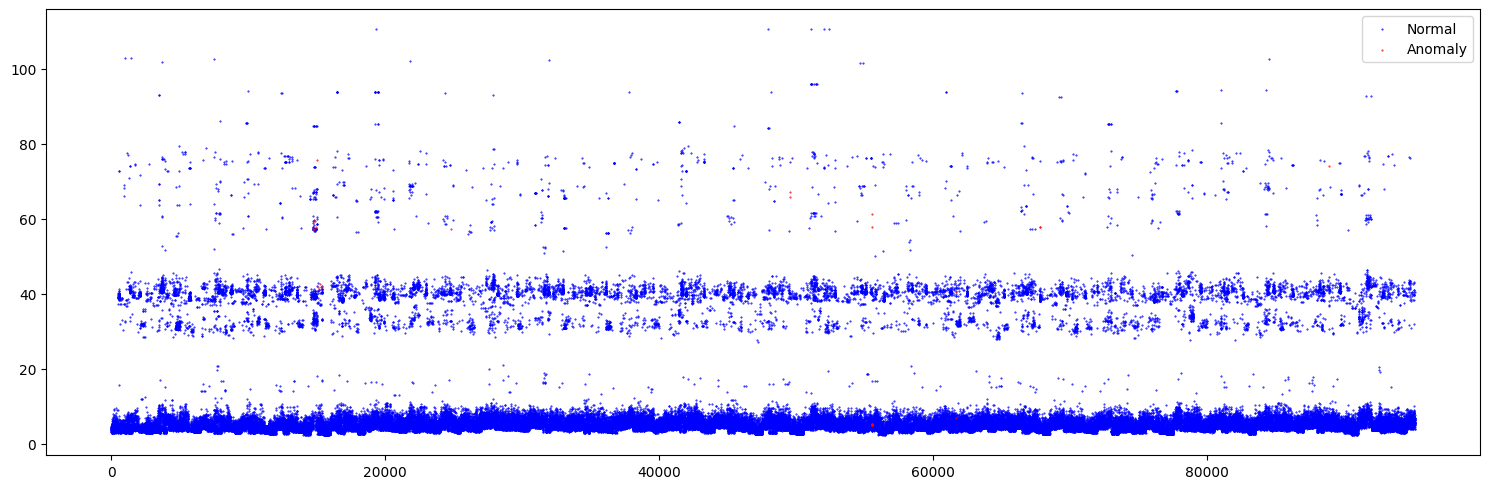

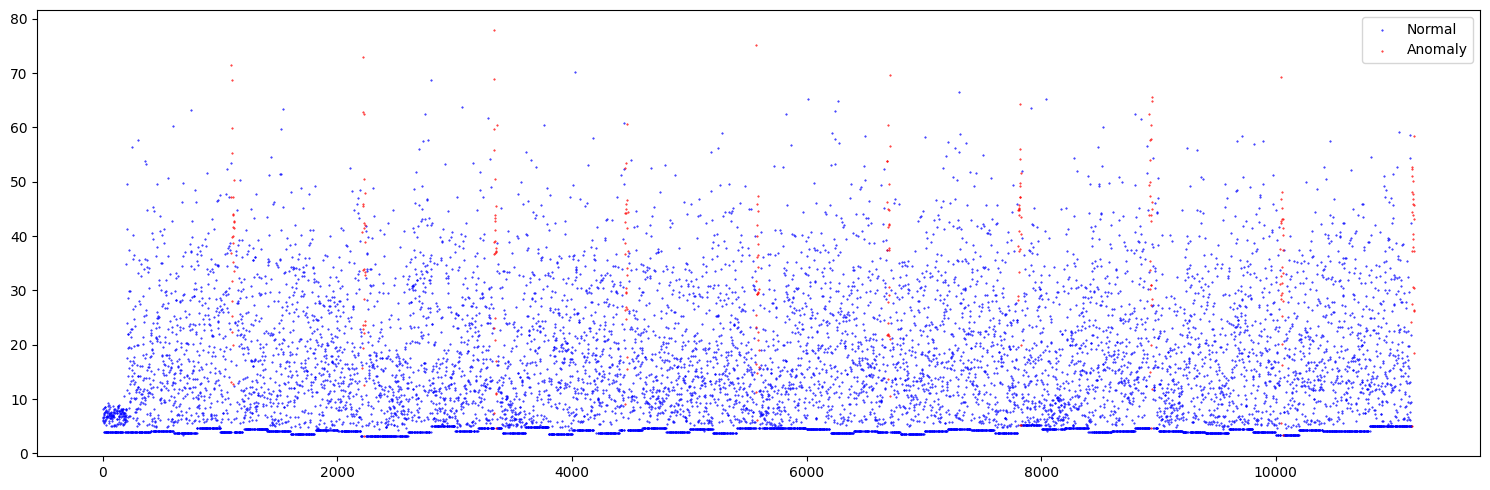

In [12]:
for d in datasets:
    aucm, aucs, bs = do_data_set_alter(d)
    results_alter.append({'dataset':d, 'mean':aucm, 'std': aucs, 'bs':bs, 'hpb':1})

In [14]:
pd.DataFrame.from_dict(results_alter).to_csv('datasets_test_alter_loda.csv')

In [15]:
pd.DataFrame.from_dict(results_alter)

,dataset,mean,std,bs,hpb
0,cover.csv,0.268092,0.020221,1400,1
1,creditcardfraud_normalised.csv,0.949679,0.002111,1400,1
2,musk.csv,0.001608,0.000585,200,1
3,http.csv,0.574720,0.014680,2800,1
4,smtp.csv,0.849663,0.012435,500,1
5,mammography.csv,0.865641,0.003210,200,1


# Creating merged table for clear overview
#### Supposing that Streaming LODA's output is in datasets_test.csv

In [18]:
alter = pd.read_csv('datasets_test_alter_loda.csv', index_col=0)
globa = pd.read_csv('lodal_global.csv', index_col=0)
stream = pd.read_csv('datasets_test.csv', index_col=0)

In [21]:
cop = stream[stream['hpb']==1].copy()

In [24]:
cop = cop.drop('hpb', axis=1)
cop = cop.drop('bs', axis=1)

In [25]:
cop

,dataset,mean,std
0,cover.csv,0.370995,0.070760
2,creditcardfraud_normalised.csv,0.944464,0.006055
4,musk.csv,0.278195,0.105282
6,http.csv,0.997439,0.001173
8,smtp.csv,0.905553,0.007039
10,mammography.csv,0.866552,0.022657


In [27]:
alter.drop(['bs', 'hpb'], axis=1, inplace=True)

In [28]:
globa.drop(['bs', 'hpb'], axis=1, inplace=True)

In [34]:
cop.columns = ['dataset', "Streaming mean", 'Streaming std']

In [35]:
globa.columns = ['dataset', "Global mean", 'Global std']

In [36]:
alter.columns = ['dataset', "Alter mean", 'Alter std']

In [39]:
from functools import reduce

dfs = [cop, globa, alter]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='dataset', how='outer'), dfs)

In [40]:
merged_df

,dataset,Streaming mean,Streaming std,Global mean,Global std,Alter mean,Alter std
0,cover.csv,0.370995,0.070760,0.897256,0.048503,0.268092,0.020221
1,creditcardfraud_normalised.csv,0.944464,0.006055,0.955358,0.002235,0.949679,0.002111
2,http.csv,0.997439,0.001173,0.983341,0.003121,0.574720,0.014680
3,mammography.csv,0.866552,0.022657,0.857336,0.018335,0.865641,0.003210
4,musk.csv,0.278195,0.105282,0.963136,0.025238,0.001608,0.000585
5,smtp.csv,0.905553,0.007039,0.915910,0.011597,0.849663,0.012435
